## __Vision Transformer (ViT)__

In [1]:
import torch 
import numpy as np 
import pandas as pd
import torch.nn as nn 
import torch.optim as optim 
import torchvision 


from torchvision.transforms import v2 
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 

We will implementing our __ViT__ model on __CIFAR10__ dataset. This dataset has $60,000$ images of size $32 \times 32$ in 10 classes with $6000$ image per class, so fairly balanced. This dataset, in addition, is already divided into $50,000$ training and $10,000$ test images. 

We will split $5,000$ off of training to create a validation set, leaving training set with $45,000$

Also, we do not need to apply every kind of augmentation on test and validation, so we wll only be normalizing them. To do that, we need to know ``mean`` and ``std``

In [2]:
#getting test_set first to capture mean and std
from torchvision.datasets import CIFAR10

root = "./data"
test_set = CIFAR10(root=root, train=False, download=True, transform=None)


Files already downloaded and verified


In [3]:
#checking correct image size and labels
image, label = test_set[10]  # Get the first sample
print(f"Image shape: {image.size}")  # PIL Image size (width, height)
print(f"Label: {label}")

Image shape: (32, 32)
Label: 0


calculating ``mean`` and ``std`` from the test set, as it will be applied there, using newer ``transform.v2`` function

In [4]:
def compute_mean_std(dataset):
    """"
    To compute Mean and Standard Deviation for each channel
    """

    mean = torch.zeros(3)  
    std = torch.zeros(3)   
    total_pixels = 0

    for image, _ in dataset:
        image = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])(image)  # Converting images to tensors
        image = image.view(3, -1)  # Flattening the image to [3, height*width]
        mean += image.sum(dim=1)   # getting the sum of pixel values for each channel
        std += (image ** 2).sum(dim=1)  #getting the sum of squared pixel values for each channel
        total_pixels += image.size(1)

    # Computing the mean and std across the entire dataset
    mean /= total_pixels
    std = torch.sqrt(std / total_pixels - (mean ** 2))

    return mean.tolist(), std.tolist()

In [5]:
mean, std = compute_mean_std(test_set)
print(f"Mean: {mean}")
print(f"Std: {std}")

Mean: [0.49421426653862, 0.4851321876049042, 0.4504099488258362]
Std: [0.24665169417858124, 0.24289007484912872, 0.26159101724624634]


Creating separate transform function for training, and for validation and testing set

In [6]:
train_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.RandomHorizontalFlip(),
    v2.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    v2.Normalize(mean=mean, std=std)
])

test_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=mean, std=std)
])

Downloading training set as well, separating validation set out of training set, apply augmentations, and finally creatign DATALOADER for each subsets

In [7]:
from torch.utils.data import DataLoader

train_set = CIFAR10(root=root, train=True, transform=train_transform, download=True)

#again same for validation set, this is to different augmentatio application 
validation_set = CIFAR10(root=root, train=True, transform=test_transform, download=True)
test_set = CIFAR10(root=root, train=False, transform=test_transform, download=True)

#separating out distinct train_set and validation set
train_set, _ = torch.utils.data.random_split(train_set, [45000, 5000],generator=torch.Generator().manual_seed(42))
_, validation_set = torch.utils.data.random_split(validation_set, [45000, 5000], generator=torch.Generator().manual_seed(42))


#Next, creating DataLoader(s)
train_loader = DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True,num_workers=2, pin_memory=True)
validation_loader = DataLoader(validation_set, batch_size=128, shuffle=True, drop_last=False ,num_workers=2)
test_loader = DataLoader(test_set, batch_size=128, shuffle=True, drop_last=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Getting some images out for visualization

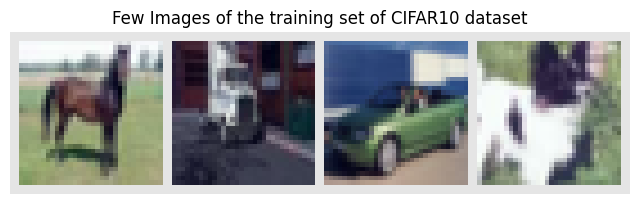

In [8]:
from torchvision.utils import make_grid

n_images = 4
CIFAR_images = torch.stack([validation_set[idx][0] for idx in range(n_images)], dim=0)
img_grid = make_grid(CIFAR_images, nrow=4, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Few Images of the training set of CIFAR10 dataset")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

In essence, Vision Transformer is an image classification model that takes images as a sequence of patches, considering those patches as word or token that can be passed onto a Transformer alongside positional & patch encoding.

We need to __flatten__ our image patches into 1D vector before passing into Transformer. For our CIFAR10 task with 32 x 32, we get 64 patches of size 4x4. Below, we can visualize our obtained image patches before flattening into 1D tensor for Transformer

In [9]:
def img_to_patch(img, patch_size, flatten_channels=True):
    """
    Args:
        img: image tensor with shape [B, C, H, w]
            where 
            B: batch size (no. of images in a batch)
            C: no. of color channels (3 in RGB)
            H: Height of image
            W: Width of image
        patch_size: no. of pixels in each dimension of patch. if 4, we have 4x4 pixels
        flatten_channel: A Boolean flag. If TRUE - flatten into feature vector, otherwise image grid
    """
    B, C, H, W = img.shape
    img = img.reshape(B, C, H//patch_size, patch_size, W//patch_size, patch_size)
    img = img.permute(0, 2, 4, 1, 3, 5) #gives (B, C, H//patch_size, W//patch_size, patch_size, patch_size)
    img = img.flatten(1,2) #[B, (H//patch_size * W//patch_size), C, patch_size, patch_size]
    if flatten_channels:
        img = img.flatten(2,4) #[B, (H//patch_size * W//patch_size), (C * patch_size * patch_size)]
    return img

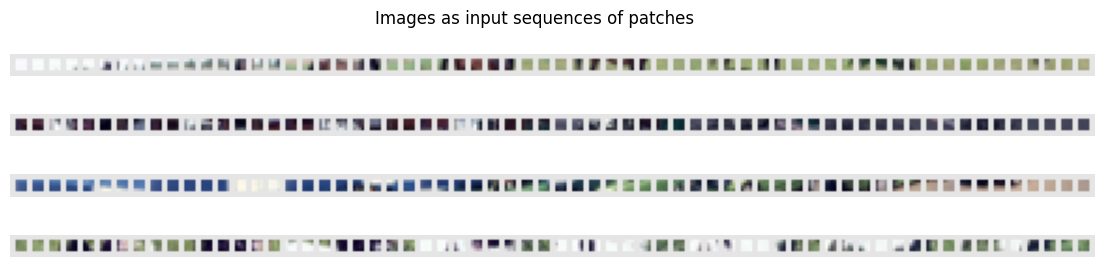

In [10]:
img_patches = img_to_patch(CIFAR_images, patch_size=4, flatten_channels=False)

fig, ax = plt.subplots(CIFAR_images.shape[0], 1, figsize=(14,3))
fig.suptitle("Images as input sequences of patches")
for i in range(CIFAR_images.shape[0]):
    img_grid = make_grid(img_patches[i], nrow=64, normalize=True, pad_value=0.9)
    img_grid = img_grid.permute(1, 2, 0)
    ax[i].imshow(img_grid)
    ax[i].axis('off')
plt.show()
plt.close()



## __Vision Transformer Architecture__

Lets divide ViT model into two parts:
- Input image representation
- Tranformer Encoder

__Input Image Representation__: Given an image of ``[H, W, C]``, we decide on ``patch_size`` P. This patch_size is used to divide image into N non-overlapping patches.

Thus, our number of patches to be passed is $N = \frac{H× W}{P^2}$, and represented as $x_p ∈ \mathbb{R}^{P^2× C}$

Each patch is then mapped into D-dimensional embedding space with trainable linear projection $E ∈ \mathbb{R}^{(P^2 ⋅ C)× D}$. The output of this operation is known as __patch embeddings__ . Afterwards, a learnable class token $x_{class}$ is prepended to the sequence of patch embeddings. The state  of $x_{class}$ at the time of output from Transformer encoder serve as representation for image label. Next, we also add $E_{pos}$, a 1D learnable positional embedding to retain positional information, to the patch embeddings.

Thus, our image input to the transformer becomes:

$$z_{0} = [x_{class}; x_{p}^1E;x_{p}^2E;\cdots;x_{p}^{N}E] + E_{pos}, \qquad E∈ \mathbb{R}^{(P^2⋅C)× D}, E_{pos}∈ \mathbb{R}^{(N+1)× D}$$

__Transformer Encoder__ : The sequence of (modified) patch embedding $z_{0}$ is passed to Transformer encoder that can have any number of $L$ layers, where each $L$ layer has 
1. __Multi-Head Self-Attention (MSA)__
2. __Multi-Layer Perceptron (MLP)__

At each layer $l$ of $L$ the input $z_{0}$ or $z_{l-1}$ is normalized using __Layer Normalization__ and first passed through MSA. After this, output of MSA is normalized again using LayerNorm and passed through MLP. MLP here has two feedforward network with GELU activation.

In equation, it can be stated as:

$z^{'}_{l} = MSA(LN(z_{l-1})) + z_{l-1}$

$z_{l} = MLP(LN(z^{'}_{l})) +z^{'}_{l}$

We get, final output form Transformer encoder after all $L$ layers as:

$z_{L} = [z_{L}^0, z_{L}^1 \cdots z_{L}^N]$ where $z_{L}^0$ is representation of class token, discussed above as outcome of $x_{class}$. This class token is used as image representation $y$ by $y = LN(z_{L}^0)$ 

Source: [Dosovitskiy, A., Beyer, L., Kolesnikov, A., Weissenborn, D., Zhai, X., Unterthiner, T., Dehghani, M., Minderer, M., Heigold, G., Gelly, S. and Uszkoreit, J., 2020. An image is worth 16x16 words: Transformers for image recognition at scale. arXiv preprint arXiv:2010.11929.](https://arxiv.org/pdf/2010.11929/1000)

In [11]:
class AttentionBlock(nn.Module):

    def __init__(self, embed_dim, hidden_dim, num_head, dropout=0.0):

        """ 
        Args:
            embed_dim: Embedding size used in LN and self-attention
            hidden_dim: Hidden layer dimension used in MLP (2-4x times of embed_dim)
            num_head: Number of head used in Multi-head self-attention
            dropout: float values for dropout
        """

        super().__init__()

        self.layer_norm1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_head, dropout=dropout)
        self.layer_norm2 = nn.LayerNorm(embed_dim)
        self.linear = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        input_x = self.layer_norm1(x)
        #input_x is passed as Query, Key, Value as it is self-attention
        x = self.attn(input_x, input_x, input_x)[0]
        x = self.linear(self.layer_norm2(x))
        
        return x


In [12]:
class VisionTransformer(nn.Module):

    def __init__(self, embed_dim, hidden_dim, num_channels, num_heads, num_layers, num_classes, patch_size, num_patches, dropout=0.0):
        """ 
        Args:
            embed_dim: Dimension of token embeddings.
            hidden_dim: Hidden layer size in feed-forward networks.
            num_channels: Number of input channels (e.g., 3 for RGB).
            num_heads: Number of attention heads in MultiheadAttention.
            num_layers: Number of Transformer layers (MSA + MLP).
            num_classes: Number of output classes (e.g., 10 for CIFAR-10).
            patch_size: Size of each image patch (4 x 4 in our case).
            num_patches: Total number of patches an image is divided into (64 in our case).
            dropout: Dropout rate.
        """

        super().__init__()

        #flattening patches in 1D vector and projecting it into Transformer embedding dimension
        self.patch_size = patch_size
        self.input_layer = nn.Linear(num_channels * (patch_size**2), embed_dim)

        #Transformer
        self.transformer = nn.Sequential(*[AttentionBlock(embed_dim, hidden_dim, num_heads, dropout=dropout) for _ in range(num_layers)])
        #MLP HEAD
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, num_classes))
        self.dropout = nn.Dropout(dropout)
        #position embedding + class token
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim)) 
        #first 1 for token across all batch, second 1 for 1 token all sequence of patches of a image
        self.pos_embedding = nn.Parameter(torch.randn(1, 1+num_patches, embed_dim)) 
        # first 1 for positional encoding for all batches, second 1+num_patches is for all patches in sequence alongwith class token

    def forward(self, x):
        #input image processing
        x = img_to_patch(x, self.patch_size) #changes [B, C, H, W] -> [B, T, C*patch_size*patch_size] where B is batch size & T is no. of patch
        B, T, _ = x.shape
        x = self.input_layer(x) # [B, T, C * patch_size * patch_size] -> [B, T, embed_dim]

        #Adding class token and positional encoding
        cls_token = self.cls_token.repeat(B, 1, 1) #repeating class token for each batch
        x = torch.cat([cls_token, x], dim=1) #[B, T, embed_dim] -> [B, T+1, embed_dim]
        x = x + self.pos_embedding[:, :T+1] #adding positional encoding [B, T+1, embed_dim] -> [B, T+1, embed_dim]

        #applying transformer
        x = self.dropout(x)
        x = x.transpose(0, 1) #[B, T+1, embed_dim] -> [T+1, B, embed_dim]
        x = self.transformer(x) 

        #classfication
        cls = x[0]
        out = self.mlp_head(cls)
        return out 

In [13]:
#Defining PARAMETERS

embed_dim =  256
hidden_dim =  512
num_channels = 3
num_heads = 8
num_layers = 6
patch_size = 4
num_patches = (32 // patch_size) * (32 // patch_size)
num_classes = 10
dropout = 0.2


Intantiating __VisionTransformer__ class and getting model parameters count

In [14]:
model = VisionTransformer(embed_dim, hidden_dim, num_channels, num_heads, num_layers, num_classes, patch_size, num_patches, dropout)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of Training Parameters: {count_parameters(model):,}")

Number of Training Parameters: 3,195,146


In [15]:
learning_rate = 3e-4
num_epochs = 30

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

def train_model(model, train_loader, validation_loader, optimizer, num_epochs):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):

        #training section
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for input_data, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):

            optimizer.zero_grad()
            outputs = model(input_data)
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss +=loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        train_accuracy = 100 * correct / total 
        train_accuracies.append(train_accuracy)

        # Validation section
        model.eval()
        val_loss, correct, total = 0.0, 0, 0

        with torch.no_grad():
            for input_data, labels in tqdm(validation_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                
                outputs = model(input_data)
                loss_fn = nn.CrossEntropyLoss()
                loss = loss_fn(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        val_loss /= len(validation_loader)  
        val_losses.append(val_loss)
        val_accuracy = 100.0 * correct / total
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs} || "
            f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}% || "
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

    return train_losses, val_losses, train_accuracies, val_accuracies

# Training
import time

start_time = time.time()
train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, validation_loader, optimizer, num_epochs)
training_time = time.time() - start_time

hours, remainder = divmod(training_time, 3600)  
minutes, seconds = divmod(remainder, 60)
print(f"Total training time: {hours} hours, {minutes} minutes, {seconds} seconds")

Epoch 1/30 - Validation: 100%|██████████| 40/40 [00:33<00:00,  1.18it/s]


Epoch 1/30 || Train Loss: 1.9886, Train Acc: 23.92% || Val Loss: 1.8396, Val Acc: 30.82%


Epoch 2/30 - Validation: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


Epoch 2/30 || Train Loss: 1.7945, Train Acc: 30.45% || Val Loss: 1.7793, Val Acc: 32.16%


Epoch 3/30 - Validation: 100%|██████████| 40/40 [00:31<00:00,  1.26it/s]


Epoch 3/30 || Train Loss: 1.7390, Train Acc: 33.18% || Val Loss: 1.6860, Val Acc: 36.72%


Epoch 4/30 - Validation: 100%|██████████| 40/40 [00:31<00:00,  1.25it/s]


Epoch 4/30 || Train Loss: 1.6927, Train Acc: 35.99% || Val Loss: 1.6493, Val Acc: 37.10%


Epoch 5/30 - Validation: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]


Epoch 5/30 || Train Loss: 1.6433, Train Acc: 38.02% || Val Loss: 1.5973, Val Acc: 40.24%


Epoch 6/30 - Validation: 100%|██████████| 40/40 [00:31<00:00,  1.26it/s]


Epoch 6/30 || Train Loss: 1.6425, Train Acc: 38.89% || Val Loss: 1.5966, Val Acc: 41.50%


Epoch 7/30 - Validation: 100%|██████████| 40/40 [00:32<00:00,  1.24it/s]


Epoch 7/30 || Train Loss: 1.6406, Train Acc: 38.87% || Val Loss: 1.6501, Val Acc: 40.76%


Epoch 8/30 - Validation: 100%|██████████| 40/40 [00:31<00:00,  1.27it/s]


Epoch 8/30 || Train Loss: 1.6597, Train Acc: 37.93% || Val Loss: 1.6685, Val Acc: 38.42%


Epoch 9/30 - Validation: 100%|██████████| 40/40 [00:31<00:00,  1.27it/s]


Epoch 9/30 || Train Loss: 1.5975, Train Acc: 40.51% || Val Loss: 1.5697, Val Acc: 42.80%


Epoch 10/30 - Validation: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]


Epoch 10/30 || Train Loss: 1.7216, Train Acc: 35.03% || Val Loss: 1.7219, Val Acc: 33.98%


Epoch 11/30 - Validation: 100%|██████████| 40/40 [00:31<00:00,  1.26it/s]


Epoch 11/30 || Train Loss: 1.6614, Train Acc: 37.42% || Val Loss: 1.6647, Val Acc: 38.26%


Epoch 12/30 - Validation: 100%|██████████| 40/40 [00:31<00:00,  1.27it/s]


Epoch 12/30 || Train Loss: 1.6970, Train Acc: 36.05% || Val Loss: 1.6940, Val Acc: 37.06%


Epoch 13/30 - Validation: 100%|██████████| 40/40 [00:31<00:00,  1.26it/s]


Epoch 13/30 || Train Loss: 1.7083, Train Acc: 34.13% || Val Loss: 1.6735, Val Acc: 36.36%


Epoch 14/30 - Validation: 100%|██████████| 40/40 [00:31<00:00,  1.27it/s]


Epoch 14/30 || Train Loss: 1.6247, Train Acc: 38.06% || Val Loss: 1.5755, Val Acc: 40.36%


Epoch 15/30 - Validation: 100%|██████████| 40/40 [00:32<00:00,  1.24it/s]


Epoch 15/30 || Train Loss: 1.6425, Train Acc: 39.08% || Val Loss: 1.6266, Val Acc: 39.48%


Epoch 16/30 - Validation: 100%|██████████| 40/40 [00:31<00:00,  1.27it/s]


Epoch 16/30 || Train Loss: 1.7105, Train Acc: 36.10% || Val Loss: 1.7122, Val Acc: 36.30%


Epoch 17/30 - Validation: 100%|██████████| 40/40 [00:31<00:00,  1.27it/s]


Epoch 17/30 || Train Loss: 1.7163, Train Acc: 34.91% || Val Loss: 1.7117, Val Acc: 33.50%


Epoch 18/30 - Validation: 100%|██████████| 40/40 [00:32<00:00,  1.25it/s]


Epoch 18/30 || Train Loss: 1.6563, Train Acc: 36.55% || Val Loss: 1.6420, Val Acc: 38.72%


Epoch 19/30 - Validation: 100%|██████████| 40/40 [00:31<00:00,  1.27it/s]


Epoch 19/30 || Train Loss: 1.5985, Train Acc: 40.00% || Val Loss: 1.5759, Val Acc: 41.48%


Epoch 20/30 - Validation: 100%|██████████| 40/40 [00:31<00:00,  1.26it/s]


Epoch 20/30 || Train Loss: 1.5719, Train Acc: 41.63% || Val Loss: 1.6064, Val Acc: 40.70%


Epoch 21/30 - Validation: 100%|██████████| 40/40 [00:31<00:00,  1.26it/s]


Epoch 21/30 || Train Loss: 1.5597, Train Acc: 42.23% || Val Loss: 1.5562, Val Acc: 43.78%


Epoch 22/30 - Validation: 100%|██████████| 40/40 [00:31<00:00,  1.26it/s]


Epoch 22/30 || Train Loss: 1.5906, Train Acc: 40.87% || Val Loss: 1.5646, Val Acc: 41.72%


Epoch 23/30 - Validation: 100%|██████████| 40/40 [00:31<00:00,  1.26it/s]


Epoch 23/30 || Train Loss: 1.5625, Train Acc: 42.15% || Val Loss: 1.5624, Val Acc: 41.86%


Epoch 24/30 - Validation: 100%|██████████| 40/40 [00:31<00:00,  1.26it/s]


Epoch 24/30 || Train Loss: 1.6258, Train Acc: 39.31% || Val Loss: 1.7439, Val Acc: 34.12%


Epoch 25/30 - Validation: 100%|██████████| 40/40 [00:31<00:00,  1.27it/s]


Epoch 25/30 || Train Loss: 1.7031, Train Acc: 36.49% || Val Loss: 1.6266, Val Acc: 39.20%


Epoch 26/30 - Validation: 100%|██████████| 40/40 [00:31<00:00,  1.26it/s]


Epoch 26/30 || Train Loss: 1.6064, Train Acc: 40.50% || Val Loss: 1.9265, Val Acc: 27.86%


Epoch 27/30 - Validation: 100%|██████████| 40/40 [00:32<00:00,  1.25it/s]


Epoch 27/30 || Train Loss: 1.6921, Train Acc: 36.45% || Val Loss: 1.8042, Val Acc: 31.08%


Epoch 28/30 - Validation: 100%|██████████| 40/40 [00:31<00:00,  1.26it/s]


Epoch 28/30 || Train Loss: 1.7403, Train Acc: 32.32% || Val Loss: 1.7142, Val Acc: 37.68%


Epoch 29/30 - Validation: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]


Epoch 29/30 || Train Loss: 1.6407, Train Acc: 38.07% || Val Loss: 1.5814, Val Acc: 42.70%


Epoch 30/30 - Validation: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]

Epoch 30/30 || Train Loss: 1.6091, Train Acc: 39.79% || Val Loss: 1.5887, Val Acc: 41.26%
Total training time: 6.0 hours, 29.0 minutes, 22.912734270095825 seconds


Plotting __Training Loss, Validation Loss__ and __Training Accuracy, Validation Accuracy__ on subsequent subplots

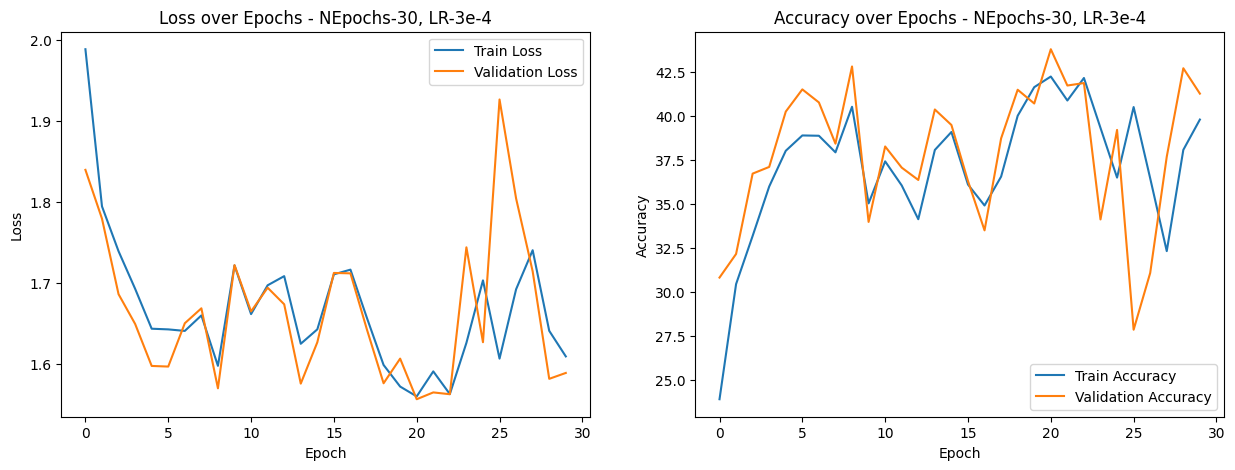

In [21]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.xticks(range(len(train_losses)))
plt.title('Loss over Epochs - NEpochs-30, LR-3e-4')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.xticks(range(len(train_losses)))
plt.title('Accuracy over Epochs - NEpochs-30, LR-3e-4')
plt.legend()

plt.savefig('Plot_num_ep_30_lr3e-4.png', dpi=300, bbox_inches='tight')
plt.show()


In [17]:
def test_model(model, test_loader):
    model.eval()
    test_loss, correct, total = 0.0, 0, 0
    predictions, all_labels = [], []
    

    with torch.no_grad():
        for input_data, labels in tqdm(test_loader):
            outputs = model(input_data)

            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(outputs, labels)

            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predictions.extend(predicted.numpy())
            all_labels.extend(labels.numpy())

    test_loss /= len(test_loader)
    test_accuracy = 100 * correct / total
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    return predictions, all_labels, test_loss, test_accuracy

start_time = time.time()
predictions, all_labels, test_loss, test_accuracy = test_model(model, test_loader)
testing_time = time.time() - start_time
print(f"Total testing time: {testing_time:.2f} seconds")

100%|██████████| 79/79 [00:51<00:00,  1.53it/s]

Test Loss: 1.5919, Test Accuracy: 41.56%
Total testing time: 51.73 seconds


Model Accuracy: 41.56%
              precision    recall  f1-score   support

    airplane       0.50      0.42      0.46      1000
  automobile       0.48      0.69      0.57      1000
        bird       0.27      0.08      0.12      1000
         cat       0.29      0.25      0.27      1000
        deer       0.41      0.39      0.40      1000
         dog       0.35      0.51      0.42      1000
        frog       0.40      0.52      0.45      1000
       horse       0.54      0.39      0.46      1000
        ship       0.49      0.65      0.56      1000
       truck       0.31      0.26      0.28      1000

    accuracy                           0.42     10000
   macro avg       0.40      0.42      0.40     10000
weighted avg       0.40      0.42      0.40     10000



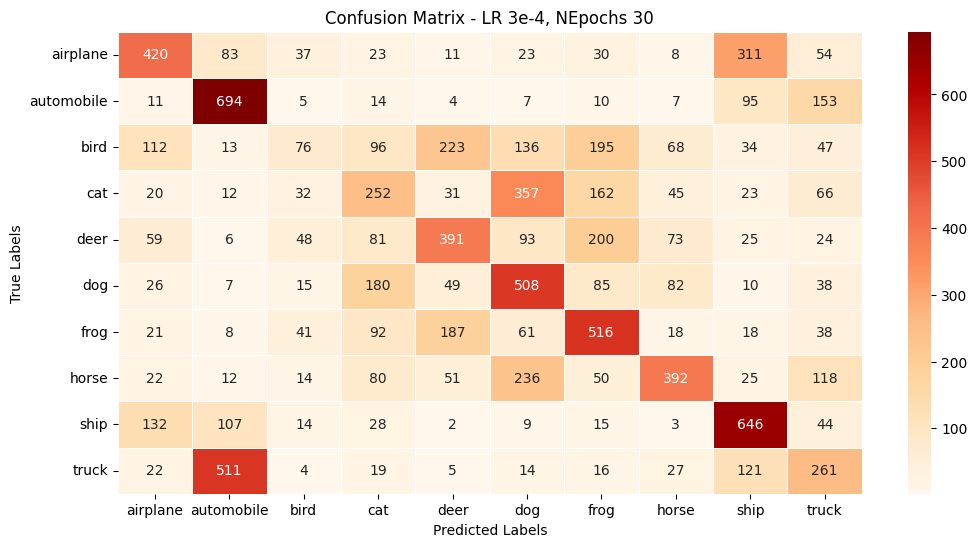

In [18]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

print(f"Model Accuracy: {accuracy_score(all_labels, predictions) * 100:.2f}%")
print(classification_report(all_labels, predictions, target_names=test_set.classes))

cm = confusion_matrix(all_labels, predictions)
plt.figure(figsize=(12, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='OrRd',linewidths=.5,
            xticklabels=test_set.classes, yticklabels=test_set.classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - LR 3e-4, NEpochs 30')
plt.savefig("Conf_mat_num_pe_30_lr3e-4.png",dpi=300,bbox_inches="tight")
plt.show()

## Results

For having computational constraint, we are not altering Transformer architecture, but only __learning rate__, (not even _epochs_, and _dropout_)

``1e-4`` and ``2e-3`` were giving lower accuracy on lesser number of epochs, so ran with ``2e-4`` as __learning rate__ for $30$ epochs.

| Ex  | Training Parameters | Training Time | Learning Rate | No. Epochs | Training Accuracy | Training Loss | Validation Accuracy | Validation Loss | MODEL ACCURACY|
|-------|------|--------|--------|----------|---------|--------|-------|-------|---------|
|1 |  3,195,146 | 6:00 Hours | 2e-4 | 30 | 61.85 | 1.0872 | 59.36 | 1.2607 | __58.71__ |
| 2 | 3,195,146 | 6:29 Hours | 3e-4 | 30 | 39.79% | 1.6091| 41.26% | 1.5887 | 41.56% |

